<a href="https://colab.research.google.com/github/Squidisverycool/ISquaredHackathon/blob/main/Lara_new_augmented_s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Upload Json file
# in order to download the file you see to go to kaggle > Settings > create an API
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oshin1","key":"9384f43e91550d4ccb9d6fee463e128a"}'}

In [ ]:
# Allow permission to the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dowload the dataset .zip
!kaggle competitions download -c i-squared-liver-ultrasound-detection

 99% 2.96G/2.99G [00:06<00:00, 355MB/s]
100% 2.99G/2.99G [00:06<00:00, 500MB/s]


In [ ]:
# Unzip th folder
!unzip i-squared-liver-ultrasound-detection.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/dataset_fixed/train_data/train_images/83439.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83447.jpg  
  inflating: data/dataset_fixed/train_data/train_images/8347.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83473.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83476.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83504.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83508.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83512.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83514.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83542.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83564.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83579.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83593.jpg  
  inflating: data/dataset_fixed/train_data/train_images/83598.jpg 

Augment

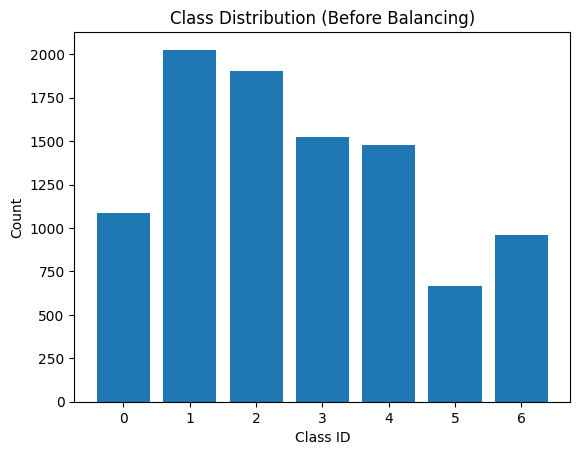

Counter({1: 2026, 2: 1903, 3: 1523, 4: 1478, 0: 1089, 6: 960, 5: 666})


In [ ]:
# Show non equal distribution
import os
import matplotlib.pyplot as plt
from collections import Counter

annotations_path = "data/dataset_fixed/train_data/train_annotations"

class_counts = Counter()

for file in os.listdir(annotations_path):
    if file.endswith(".txt"):
        with open(os.path.join(annotations_path, file)) as f:
            for line in f:
                label = int(line.split()[0])
                class_counts[label] += 1

plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution (Before Balancing)")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

print(class_counts)

In [ ]:
# Check the negative images
from pathlib import Path

src_img_dir = Path("data/dataset_fixed/train_data/train_images")
src_ann_dir = Path("data/dataset_fixed/train_data/train_annotations")

missing = 0
for img_path in src_img_dir.glob("*.jpg"):
    ann_path = src_ann_dir / (img_path.stem + ".txt")
    if not ann_path.exists():
        missing += 1

print(f"Missing annotations for {missing} out of {len(list(src_img_dir.glob('*.jpg')))} images.")

Missing annotations for 8000 out of 15999 images.


In [ ]:
# Remove New_test
from pathlib import Path

# --- Delete existing New_train folder if it exists ---
dst_dir = Path("data/dataset_fixed/New_train")
if dst_dir.exists():
    rmtree(dst_dir)

In [ ]:
# Separate different classes in training set, including negatives for missing txt files

import os
from pathlib import Path
from shutil import copy2, rmtree

# --- Paths ---
src_img_dir = Path("data/dataset_fixed/train_data/train_images")
src_ann_dir = Path("data/dataset_fixed/train_data/train_annotations")

dst_dir = Path("data/dataset_fixed/separate_train")

# --- Remove old folder if exists ---
if dst_dir.exists():
    rmtree(dst_dir)
dst_dir.mkdir(parents=True, exist_ok=True)

# --- Create class folders 0-6, mixed, and negative ---
class_folders = {}
for i in range(7):
    class_folders[i] = dst_dir / f"class_{i}"
    (class_folders[i] / "images").mkdir(parents=True, exist_ok=True)
    (class_folders[i] / "annotations").mkdir(parents=True, exist_ok=True)

mixed_folder = dst_dir / "mixed"
(mixed_folder / "images").mkdir(parents=True, exist_ok=True)
(mixed_folder / "annotations").mkdir(parents=True, exist_ok=True)

negative_folder = dst_dir / "negative/negative_images"
negative_folder.mkdir(parents=True, exist_ok=True)

# --- Process each image ---
for img_file in src_img_dir.glob("*.jpg"):
    ann_file = src_ann_dir / f"{img_file.stem}.txt"

    if not ann_file.exists():
        # No annotation file → negative image
        copy2(img_file, negative_folder / img_file.name)
        continue

    with open(ann_file) as f:
        lines = [line.strip() for line in f if line.strip()]

    if not lines:
        # Empty annotation → negative image
        copy2(img_file, negative_folder / img_file.name)
        continue

    # Find all classes in this annotation
    labels_in_file = set(int(line.split()[0]) for line in lines)

    if len(labels_in_file) == 1:
        # All boxes same class → copy to corresponding class folder
        class_label = labels_in_file.pop()
        copy2(img_file, class_folders[class_label] / "images" / img_file.name)
        copy2(ann_file, class_folders[class_label] / "annotations" / ann_file.name)
    else:
        # Mixed classes → copy to mixed folder
        copy2(img_file, mixed_folder / "images" / img_file.name)
        copy2(ann_file, mixed_folder / "annotations" / ann_file.name)

print("✅ All images separated by class, mixed, and negatives (including missing txt files).")

✅ All images separated by class, mixed, and negatives (including missing txt files).


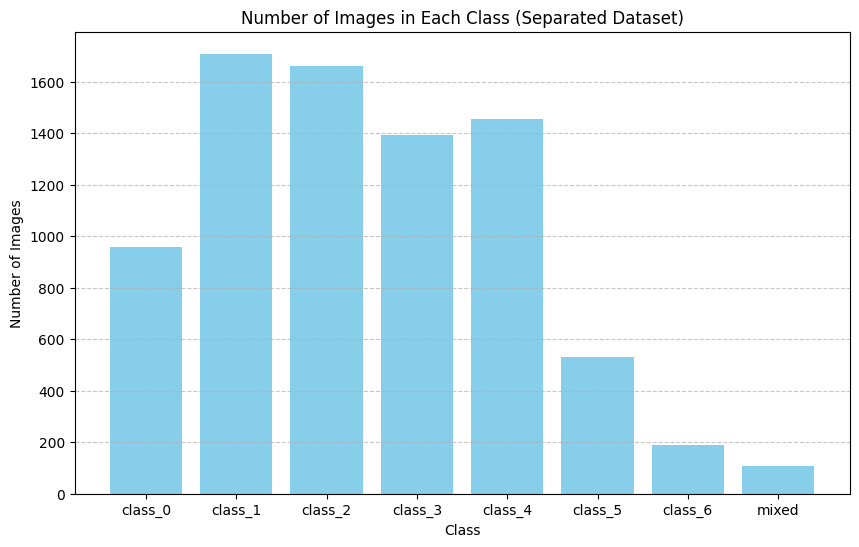

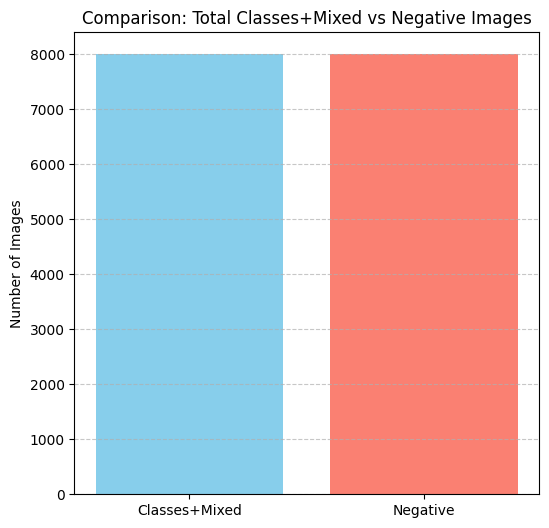

In [ ]:
# Visualize

from pathlib import Path
import matplotlib.pyplot as plt

# --- Path to the separated dataset ---
separate_dir = Path("data/dataset_fixed/separate_train")

# --- Count images in each class 0-6 ---
class_counts = {}
for i in range(7):
    img_dir = separate_dir / f"class_{i}" / "images"
    class_counts[f"class_{i}"] = len(list(img_dir.glob("*.jpg")))

# --- Count mixed images ---
mixed_img_dir = separate_dir / "mixed" / "images"
class_counts["mixed"] = len(list(mixed_img_dir.glob("*.jpg")))

# --- Count negative images ---
negative_img_dir = separate_dir / "negative/negative_images"
negative_count = len(list(negative_img_dir.glob("*.jpg")))

# --- First bar chart: classes + mixed ---
plt.figure(figsize=(10,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Class (Separated Dataset)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Second bar chart: sum of classes + mixed vs negative ---
total_classes_mixed = sum(class_counts.values())
plt.figure(figsize=(6,6))
plt.bar(["Classes+Mixed", "Negative"], [total_classes_mixed, negative_count], color=['skyblue', 'salmon'])
plt.ylabel("Number of Images")
plt.title("Comparison: Total Classes+Mixed vs Negative Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Augmenting classes ignoring the mixed

import cv2
import numpy as np
import random
from pathlib import Path
from shutil import copy2, rmtree
from collections import Counter
import matplotlib.pyplot as plt

# --- Paths ---
separate_dir = Path("data/dataset_fixed/separate_train")
balanced_dir = Path("data/dataset_fixed/balanced_train")

# --- Remove old balanced folder if exists ---
if balanced_dir.exists():
    rmtree(balanced_dir)
balanced_dir.mkdir(parents=True, exist_ok=True)

# --- Helper: simple augmentations that do NOT change bounding boxes ---
def augment_image(img):
    choice = random.choice(["bright", "contrast", "gamma"])  # removed "noise"
    aug = img.copy()
    if choice == "bright":
        factor = random.uniform(0.7, 1.3)
        aug = np.clip(img * factor, 0, 255).astype(np.uint8)
    elif choice == "contrast":
        alpha = random.uniform(0.8, 1.4)
        beta = random.randint(-20, 20)
        aug = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    elif choice == "gamma":
        gamma = random.uniform(0.7, 1.4)
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in np.arange(256)]).astype("uint8")
        aug = cv2.LUT(img, table)
    return aug
# --- Step 1: Identify maximum class count ---
class_counts = {}
for i in range(7):
    img_dir = separate_dir / f"class_{i}" / "images"
    class_counts[i] = len(list(img_dir.glob("*.jpg")))

TARGET_COUNT = max(class_counts.values())
print(f"Target images per class: {TARGET_COUNT}")

# --- Step 2: Augment each class separately ---
for i in range(7):
    src_img_dir = separate_dir / f"class_{i}" / "images"
    src_ann_dir = separate_dir / f"class_{i}" / "annotations"

    dst_img_dir = balanced_dir / f"class_{i}" / "images"
    dst_ann_dir = balanced_dir / f"class_{i}" / "annotations"
    dst_img_dir.mkdir(parents=True, exist_ok=True)
    dst_ann_dir.mkdir(parents=True, exist_ok=True)

    # Copy original images and annotations
    files = list(src_img_dir.glob("*.jpg"))
    for img_path in files:
        copy2(img_path, dst_img_dir / img_path.name)
        copy2(src_ann_dir / f"{img_path.stem}.txt", dst_ann_dir / f"{img_path.stem}.txt")

    current_count = len(files)
    aug_idx = 0

    while current_count < TARGET_COUNT:
        # Randomly select a file to augment
        img_path = random.choice(files)
        ann_path = src_ann_dir / f"{img_path.stem}.txt"

        img = cv2.imread(str(img_path))
        aug_img = augment_image(img)

        aug_name = f"{img_path.stem}_aug{aug_idx}.jpg"
        cv2.imwrite(dst_img_dir / aug_name, aug_img)
        copy2(ann_path, dst_ann_dir / f"{img_path.stem}_aug{aug_idx}.txt")

        current_count += 1
        aug_idx += 1

    print(f"✅ Class {i} balanced: {current_count} images")

# --- Step 3: Verify and plot final distribution ---
final_counts = {}
for i in range(7):
    img_dir = balanced_dir / f"class_{i}" / "images"
    final_counts[i] = len(list(img_dir.glob("*.jpg")))

print("\nFinal class distribution after augmentation:")
print(final_counts)

Target images per class: 1709
✅ Class 0 balanced: 1709 images
✅ Class 1 balanced: 1709 images
✅ Class 2 balanced: 1709 images
✅ Class 3 balanced: 1709 images
✅ Class 4 balanced: 1709 images
✅ Class 5 balanced: 1709 images
✅ Class 6 balanced: 1709 images

Final class distribution after augmentation:
{0: 1709, 1: 1709, 2: 1709, 3: 1709, 4: 1709, 5: 1709, 6: 1709}


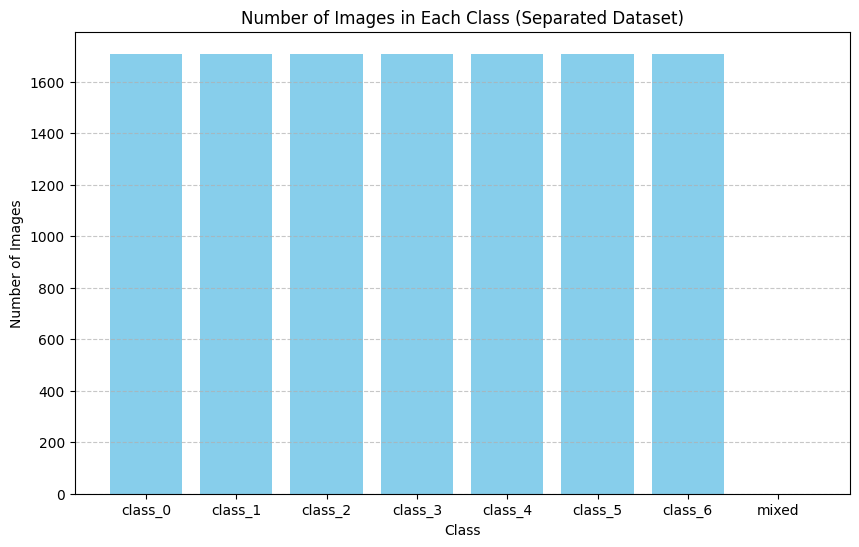

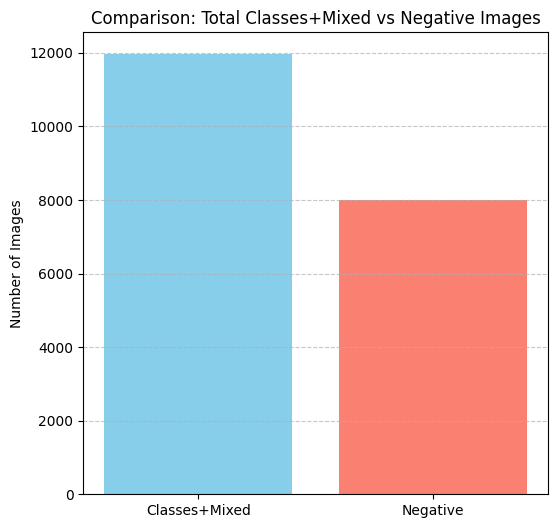

In [ ]:
# Visualize

from pathlib import Path
import matplotlib.pyplot as plt

# --- Path to the separated dataset ---
separate_dir = Path("data/dataset_fixed/balanced_train")

# --- Count images in each class 0-6 ---
class_counts = {}
for i in range(7):
    img_dir = separate_dir / f"class_{i}" / "images"
    class_counts[f"class_{i}"] = len(list(img_dir.glob("*.jpg")))

# --- Count mixed images ---
mixed_img_dir = separate_dir / "mixed" / "images"
class_counts["mixed"] = len(list(mixed_img_dir.glob("*.jpg")))

# --- Count negative images ---
negative_img_dir = Path("data/dataset_fixed/separate_train/negative/negative_images")
negative_count = len(list(negative_img_dir.glob("*.jpg")))

# --- First bar chart: classes + mixed ---
plt.figure(figsize=(10,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Class (Separated Dataset)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Second bar chart: sum of classes + mixed vs negative ---
total_classes_mixed = sum(class_counts.values())
plt.figure(figsize=(6,6))
plt.bar(["Classes+Mixed", "Negative"], [total_classes_mixed, negative_count], color=['skyblue', 'salmon'])
plt.ylabel("Number of Images")
plt.title("Comparison: Total Classes+Mixed vs Negative Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Augmenting the negative
import os
from pathlib import Path
import cv2
import numpy as np
from albumentations import Compose, RandomBrightnessContrast, VerticalFlip, Rotate
from shutil import copy2, rmtree

# --- Paths ---
negative_dir = Path("data/dataset_fixed/separate_train/negative/negative_images")
balanced_negative_dir = Path("data/dataset_fixed/balanced_train/negative")

# --- Remove old balanced negative folder if exists ---
if balanced_negative_dir.exists():
    rmtree(balanced_negative_dir)
balanced_negative_dir.mkdir(parents=True, exist_ok=True)

# --- Target number of negative images ---
target_count = 11963
existing_images = list(negative_dir.glob("*.jpg"))

# --- Define augmentation pipeline ---
aug_pipeline = Compose([
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    VerticalFlip(p=0.5),  # vertical flip only
    Rotate(limit=30, interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, p=0.5)
])

# --- Copy original negative images first ---
for img_path in existing_images:
    copy2(img_path, balanced_negative_dir / img_path.name)

# --- Augment images until target count is reached ---
while len(list(balanced_negative_dir.glob("*.jpg"))) < target_count:
    img_path = np.random.choice(existing_images)
    img = cv2.imread(str(img_path))

    augmented = aug_pipeline(image=img)
    aug_img = augmented['image']

    # Save augmented image with unique name
    new_name = f"{img_path.stem}_aug_{np.random.randint(1e6)}.jpg"
    cv2.imwrite(str(balanced_negative_dir / new_name), aug_img)

print(f"✅ Balanced negative images saved in {balanced_negative_dir}. Total: {len(list(balanced_negative_dir.glob('*.jpg')))}")

In [ ]:
# Visualize

from pathlib import Path
import matplotlib.pyplot as plt

# --- Path to the separated dataset ---
separate_dir = Path("data/dataset_fixed/balanced_train")

# --- Count images in each class 0-6 ---
class_counts = {}
for i in range(7):
    img_dir = separate_dir / f"class_{i}" / "images"
    class_counts[f"class_{i}"] = len(list(img_dir.glob("*.jpg")))

# --- Count mixed images ---
mixed_img_dir = separate_dir / "mixed" / "images"
class_counts["mixed"] = len(list(mixed_img_dir.glob("*.jpg")))

# --- Count negative images ---
negative_img_dir = separate_dir / "negative"
negative_count = len(list(negative_img_dir.glob("*.jpg")))

# --- First bar chart: classes + mixed ---
plt.figure(figsize=(10,6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each Class (Separated Dataset)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Second bar chart: sum of classes + mixed vs negative ---
total_classes_mixed = sum(class_counts.values())
plt.figure(figsize=(6,6))
plt.bar(["Classes+Mixed", "Negative"], [total_classes_mixed, negative_count], color=['skyblue', 'salmon'])
plt.ylabel("Number of Images")
plt.title("Comparison: Total Classes+Mixed vs Negative Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Merge

In [ ]:
# Merge the separate balanced train files into one YOLO-ready folder
from pathlib import Path
from shutil import copy2, rmtree

# --- Paths ---
balanced_dir = Path("data/dataset_fixed/balanced_train")
negative_dir = Path("data/dataset_fixed/balanced_train/negative")
new_train_dir = Path("data/dataset_fixed/New_train")

# --- Remove old New_train folder if exists ---
if new_train_dir.exists():
    rmtree(new_train_dir)

# --- Create the new YOLO-ready directory ---
new_train_dir.mkdir(parents=True, exist_ok=True)

# --- Merge all class folders (0–6) ---
for class_folder in balanced_dir.glob("class_*"):
    img_dir = class_folder / "images"
    ann_dir = class_folder / "annotations"

    for img_path in img_dir.glob("*.jpg"):
        copy2(img_path, new_train_dir / img_path.name)

    for ann_path in ann_dir.glob("*.txt"):
        copy2(ann_path, new_train_dir / ann_path.name)

# --- Merge negative images (no annotations) ---
for img_path in negative_dir.glob("*.jpg"):
    copy2(img_path, new_train_dir / img_path.name)

print("✅ All positive classes and negatives merged into one YOLO-ready folder.")
print(f"📂 Final folder: {new_train_dir}")
print(f"🖼️ Total images: {len(list(new_train_dir.glob('*.jpg')))}")
print(f"📄 Total labels: {len(list(new_train_dir.glob('*.txt')))}")


In [ ]:
# Merge the separate validation data into one YOLO-ready folder
from pathlib import Path
from shutil import copy2, rmtree

# --- Paths ---
val_dir = Path("/content/data/dataset_fixed/val_data")
new_val_dir = Path("/content/data/dataset_fixed/New_val")

val_img_dir = val_dir / "val_images"
val_ann_dir = val_dir / "val_annotations"

# --- Remove old New_val folder if exists ---
if new_val_dir.exists():
    rmtree(new_val_dir)

# --- Create new folder ---
new_val_dir.mkdir(parents=True, exist_ok=True)

# --- Copy all images ---
for img_path in val_img_dir.glob("*.jpg"):
    copy2(img_path, new_val_dir / img_path.name)

# --- Copy all labels ---
for ann_path in val_ann_dir.glob("*.txt"):
    copy2(ann_path, new_val_dir / ann_path.name)

print("✅ Validation images and annotations merged into one YOLO-ready folder.")
print(f"📂 Final folder: {new_val_dir}")
print(f"🖼️ Total images: {len(list(new_val_dir.glob('*.jpg')))}")
print(f"📄 Total labels: {len(list(new_val_dir.glob('*.txt')))}")


Train

In [ ]:
# --- Install YOLOv8 ---
!pip install ultralytics -q

In [ ]:
# --- Train YOLOv8 Model (Optimized) ---

from ultralytics import YOLO
from pathlib import Path

# --- Paths ---
train_images = "/content/data/dataset_fixed/New_train"
train_labels = "/content/data/dataset_fixed/New_train"

val_images = "/content/data/dataset_fixed/New_val"
val_labels = "/content/data/dataset_fixed/New_val"

# --- Create YOLO dataset YAML ---
dataset_yaml = """
path: /content/data/dataset_fixed
train: New_train
val: New_val

nc: 7
names: ['FFC', 'FFS', 'HCC', 'cyst', 'hemangioma', 'dysplastic', 'CCA']
"""

yaml_path = "/content/data/dataset_fixed/dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(dataset_yaml)

# --- Initialize YOLOv8n (nano) ---
model = YOLO("yolov11s.pt")

# --- Train ---
# Optimized: 30 epochs + early stopping patience
model.train(
    data=yaml_path,
    epochs=80,           # initial epochs
    imgsz=640,           # image size
    batch=16,            # adjust to GPU memory
    device=0,            # GPU
    patience=10,         # stop if val loss not improving for 10 epochs
    augment=False,
    name="liver_ultrasound_yolo_optimized",
    plots=True,          # visualize metrics during training
)

# --- Best model path for inference ---
best_model_path = "runs/train/liver_ultrasound_yolo_optimized/weights/best.pt"
print(f"✅ Training complete! Best model saved at: {best_model_path}")

In [ ]:
# Check mAP50
from ultralytics import YOLO

model = YOLO("/content/runs/detect/liver_ultrasound_yolo_optimized/weights/best.pt")
metrics = model.val(data="/content/data/dataset_fixed/dataset.yaml")

print(metrics.box.map50)       # mAP@0.5


Save submission

In [ ]:
import pandas as pd
from pathlib import Path
from ultralytics import YOLO

best_model_path = "/content/runs/detect/liver_ultrasound_yolo_optimized/weights/best.pt"

# Load trained model
model = YOLO(best_model_path)

# Predict on test images
test_images = "/content/data/dataset_fixed/test_data/test_images"
results = model.predict(test_images, imgsz=640, conf=0.25)

# Create submission DataFrame
submission = []

for r in results:
    img_name = Path(r.path).name
    num_boxes = len(r.boxes)

    if num_boxes > 0:
        # Add one row per detected box
        for i, (xywh, cls, conf) in enumerate(zip(r.boxes.xywhn, r.boxes.cls, r.boxes.conf)):
            x, y, w, h = xywh.tolist()
            submission.append({
                "id": f"{img_name}_{i+1}",
                "label": int(cls),
                "x": x,
                "y": y,
                "w": w,
                "h": h,
                "confidence": float(conf)
            })
    else:
        # Add a single -1 row for no detections
        submission.append({
            "id": f"{img_name}_1",
            "label": -1,
            "x": 0.0,
            "y": 0.0,
            "w": 0.0,
            "h": 0.0,
            "confidence": 0.0
        })

# Save submission
df = pd.DataFrame(submission)
df.to_csv("submission.csv", index=False)
print(f"✅ Submission saved as submission.csv ({len(df)} rows)")


In [ ]:
import pandas as pd

# Load initial submission
df = pd.read_csv("submission.csv")

# Get all unique images (remove _i suffix)
images = df['id'].apply(lambda x: "_".join(x.split("_")[:-1])).unique()

new_submission = []

for img in images:
    # Get all rows for this image
    rows = df[df['id'].str.startswith(img)].copy()

    # Add existing rows first
    for _, row in rows.iterrows():
        new_submission.append(row.to_dict())

    # Fill up remaining rows to reach 20
    for i in range(len(rows), 20):
        new_submission.append({
            "id": f"{img}_{i+1}",
            "label": -1,
            "x": 0.0,
            "y": 0.0,
            "w": 0.0,
            "h": 0.0,
            "confidence": 0.0
        })

# Save new CSV
df_new = pd.DataFrame(new_submission)
df_new.to_csv("submission20.csv", index=False)
print("✅ New submission saved as submission20.csv")